In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 1s (172 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
39 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acqu

In [ ]:
"""per poter utilizzare spark creo spark session"""
spark = SparkSession.builder.getOrCreate()

"""creo cartella con os in colab"""


os.makedirs("/content/my_catalog/raw/datasets", exist_ok=True)
"""scarico file con !curl inserendo l'url"""

!curl -L "https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv" \
    -o "/content/my_catalog/raw/datasets/bitcoin_tweets.csv"

""" carico dataset con spark"""

path = "/content/my_catalog/raw/datasets/bitcoin_tweets.csv"
df = spark.read.csv(path, header=True, inferSchema=True)


df.show(5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.5M  100 23.5M    0     0  8083k      0  0:00:02  0:00:02 --:--:-- 8080k
+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|                  id|         user|           fullname| url|           timestamp|replies|likes|retweets|                text|
+--------------------+-------------+-------------------+----+--------------------+-------+-----+--------+--------------------+
|1.132977055300300...| KamdemAbdiel|      Abdiel kamdem|NULL|2019-05-27 11:49:...|    0.0|  0.0|     0.0|È appena uscito u...|
|1.132977073402736...|    bitcointe|          Bitcointe|NULL|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Cardano: Digitize...|
|1.132977023893139...|    3eyedbran|Bran - 3 Eyed Raven|NULL|2019-05-27 11:49:...|    0.0|  2.0|     1.0|Another Test twee...|
|

In [ ]:
"""installazione vader per sentiment analisi
!pip install langdetect nlkt


from pyspark.sql.functions import udf, to_date, col, length
from pyspark.sql.types import StringType, BooleanType
import nltk

# Scarica risorse NLTK (solo la prima volta)
nltk.download('punkt')
nltk.download('stopwords')

"""

"installazione vader per sentiment analisi\n!pip install langdetect nlkt\n\n\nfrom pyspark.sql.functions import udf, to_date, col, length\nfrom pyspark.sql.types import StringType, BooleanType\nimport nltk\n\n# Scarica risorse NLTK (solo la prima volta)\nnltk.download('punkt')\nnltk.download('stopwords')\n\n"

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from langdetect import detect
from pyspark.sql.functions import udf, to_date, col, length
from pyspark.sql.types import StringType, BooleanType
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
analyzer = SentimentIntensityAnalyzer()

"""definisco funzione per capire se il testo è in lingua inglese"""
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False
""" trasformo in udf spark"""
is_english_udf = udf(is_english, BooleanType())

""" definisco funzione per pulire il testo importo librerie nella funzione e rimuovo stopwords con nltk"""
def clean_text(text):
    import re
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    if text is None:
        return ""
    text = re.sub(r"http\S+|www\S+", "", text)# Rimozione URL
    text = re.sub(r"@\w+", "", text)# Rimozione menzioni @
    text = re.sub(r"#", "", text) # Rimozione hashtag
    text = re.sub(r"[^a-zA-Z\s]", " ", text) # Rimozione caratteri speciali e numeri
    text = text.lower().strip()# Minuscolo
    stop_words = set(stopwords.words("english"))   # Stopwords
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)
""" trasformo in udf spark"""
clean_text_udf = udf(clean_text, StringType())


"""definisco funzione per sentiment analysis utilizzando vader"""
def sentiment(text_filtered):
    if text_filtered is None or text_filtered.strip() == "":
        return "neutral"
    scores = analyzer.polarity_scores(text_filtered)
    compound = scores['compound']
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

"""trasformo in udf spark"""

sentiment_udf = udf(sentiment, StringType())

"""rimuovo da text dati nulli"""
df = df.na.drop(subset=["text"])

"""utilizzo funzioni create prima per pulizia e sentiment analysis aggiungo colonna clean_text,
filtro tweet solo maggiori di 5 caratteri in lunghezza e filtro solo quelli in lingua inglese
aggiungo dopo aver applicato la funzione sentiment la colonna sentiment e date"""

df = df.withColumn("clean_text", clean_text_udf(col("text")))
df = df.filter(length(col("clean_text")) > 5)
df = df.filter(is_english_udf(col("clean_text")))

df_sentiment = df.withColumn("sentiment", sentiment_udf(col("clean_text"))) \
                 .withColumn("date", to_date(col("timestamp")))

df_sentiment.show(5)
""" a volte il sentiment non è classificato correttamente ma ho provato anche con altre librerie specifiche per crypto e notavo comunque errori.
 Ho deciso quindi di proseguire e considerare gli errori accettabili"""


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


+--------------------+------------+-------------------+----+--------------------+-------+-----+--------+--------------------+--------------------+---------+----------+
|                  id|        user|           fullname| url|           timestamp|replies|likes|retweets|                text|          clean_text|sentiment|      date|
+--------------------+------------+-------------------+----+--------------------+-------+-----+--------+--------------------+--------------------+---------+----------+
|1.132977073402736...|   bitcointe|          Bitcointe|NULL|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Cardano: Digitize...|cardano digitize ...| negative|2019-05-27|
|1.132977023893139...|   3eyedbran|Bran - 3 Eyed Raven|NULL|2019-05-27 11:49:...|    0.0|  2.0|     1.0|Another Test twee...|another test twee...|  neutral|2019-05-27|
|1.132977092340191...|mmursaleen72| Muhammad Mursaleen|NULL|2019-05-27 11:49:...|    0.0|  0.0|     0.0|Spiv (Nosar Baz):...|spiv nosar baz bi...| positive|2019

' a volte il sentiment non è classificato correttamente ma ho provato anche con altre librerie specifiche per crypto e notavo comunque errori. Ho deciso quindi di proseguire e considerare gli errori accettabili'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col
from pyspark.sql.functions import date_trunc

"""GRAFICI TEMPORALI"""

""" Prendo il dataframe con i sentiment raggruppo per mese e Conto i tweet """
monthly_sentiment = (
    df_sentiment.groupBy(date_trunc("month", col("date")).alias("month"), "sentiment")
    .count()
    .orderBy("month")
)

"""converto il dataframe ottenuto in pandas in modo da poter utilizzare le librerie di visualizzazione
e converto la series month in formato datetime"""
pdf_monthly = monthly_sentiment.toPandas()
pdf_monthly["month"] = pd.to_datetime(pdf_monthly["month"])

"""pivot per avere i sentiment come colonne, come indice i mesi e come valori i conteggi dei tweets"""
sentiment_pivot_monthly = pdf_monthly.pivot(
    index="month",
    columns="sentiment",
    values="count"
).fillna(1).sort_index()



def plot_sentiment(pivot_table, title="Andamento del sentiment", xlabel="Mesi"):
    plt.figure(figsize=(18, 7))
    for sentiment in pivot_table.columns:
        sns.lineplot(
            x=pivot_table.index,
            y=pivot_table[sentiment],
            label=str(sentiment)
        )
    plt.xlabel(xlabel)
    plt.ylabel("Numero di Tweets (scala logaritmica)")
    plt.yscale("log")
    plt.title(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


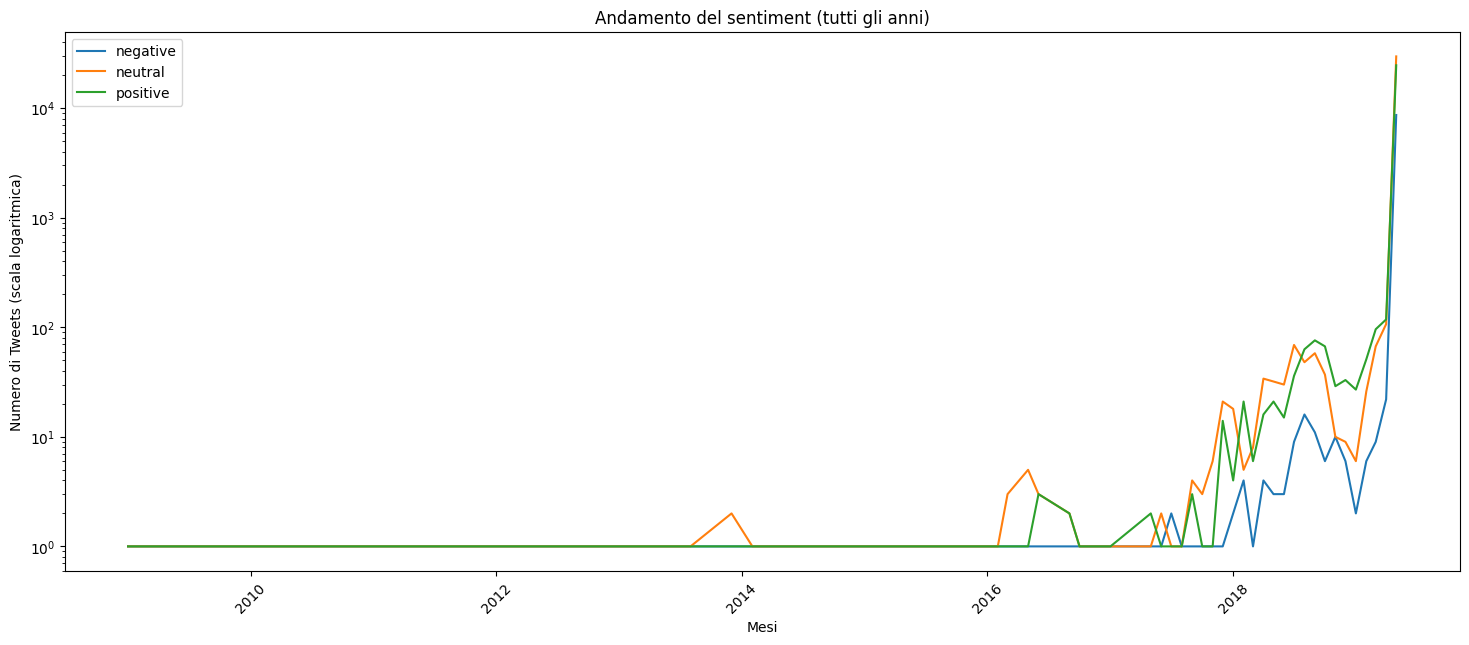

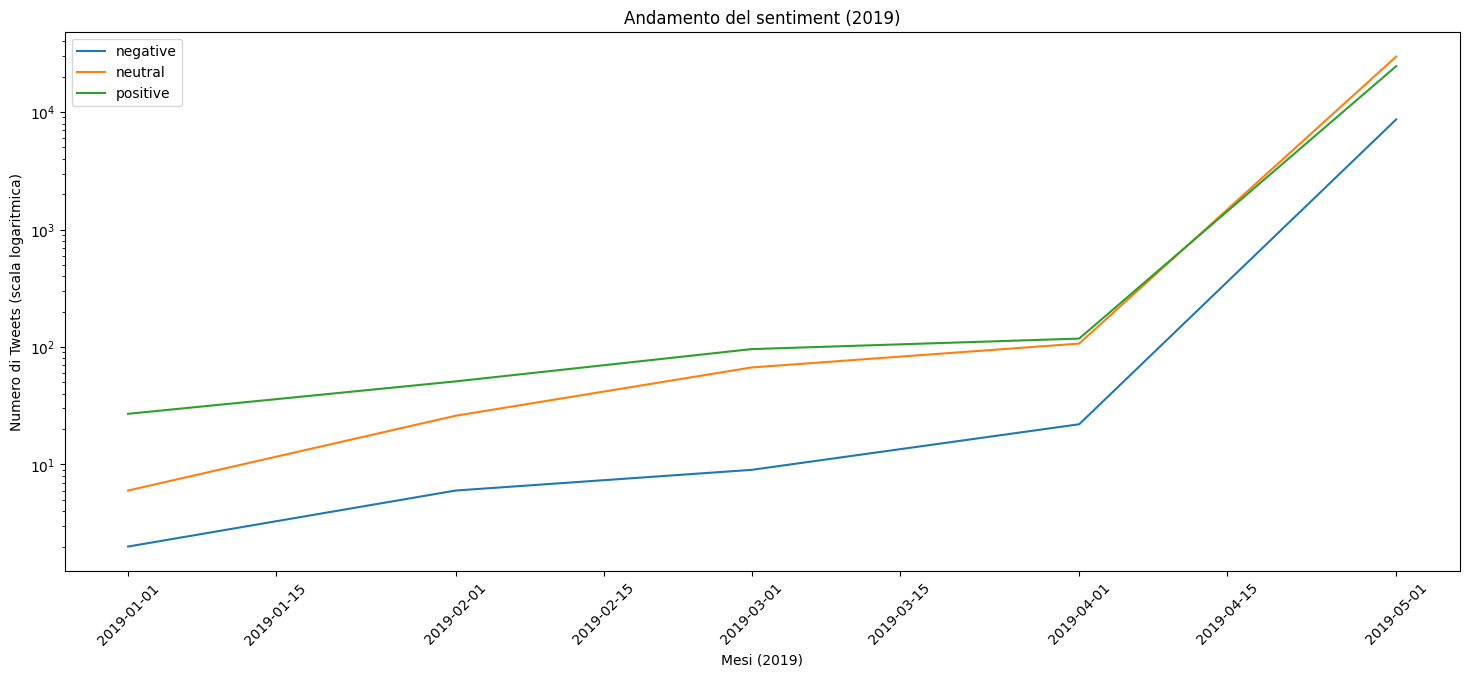

si nota in generale un'andamento creascente per tutte e tre le tipologie di sentiment con picco nell'anno 2019 segno che l'argomento è di interesse crescente. 

         dopo un lieve calo tra fine 2018 e inizio 2019 si notare un ulteriore incremento con il raggiungimento del picco. 

       I sentiment positivo e neutrale hanno un andamento simile e spesso si superano l'un l'altro 

        in particolare nel 2019 sembra che il consenso del pubblicoin merito ai bitcoin sia particolarmente positivo


In [ ]:
"""GRAFICO 1

Andamento del sentiment base mensile
definisco funzione per poterla poi eventualmente richiamare
inizio facendo un ciclo per creare una linea per ogni sentiment


aggiungo poi al grafico le labels, titolo e legenda e imposto l'asse y su scala logaritmica
titolo e x label vanno passati alla funzione quando richiamo la funzione

"""

plot_sentiment(sentiment_pivot_monthly, title="Andamento del sentiment (tutti gli anni)")


"""GRAFICO N 2
Si nota dal primo grafico che il numero di tweet maggiore si concentra dopo il 2018 e che c'è un picco
nel 2019 quindi come suggerito concentro il grafico su questo anno
limitando l'indice della pivot table al 2019
richiamo poi la funzione passandogli il dataframe filtrato per il 2019
"""


sentiment_2019 = sentiment_pivot_monthly[
    (sentiment_pivot_monthly.index >= "2019-01-01") &
    (sentiment_pivot_monthly.index <= "2019-12-31")
]
plot_sentiment(sentiment_2019, title="Andamento del sentiment (2019)", xlabel="Mesi (2019)")

print("""si nota in generale un'andamento creascente per tutte e tre le tipologie di sentiment con picco nell'anno 2019 segno che l'argomento è di interesse crescente. \n
         dopo un lieve calo tra fine 2018 e inizio 2019 si può notare un ulteriore incremento con il raggiungimento del picco. \n
       I sentiment positivo e neutrale hanno un andamento simile e spesso si superano l'un l'altro \n
        in particolare nel 2019 sembra che il consenso del pubblicoin merito ai bitcoin sia particolarmente positivo""")

In [ ]:
"""Media likes per tweet positivo/negativo"""

likes_per_tweets = (
    df_sentiment.filter(col("sentiment").isin(["positive", "negative"])) ##filtro il sentiment
    .groupBy("sentiment") ##raggruppo per tipologia di sentiment
    .agg({"likes": "avg"}) ## faccio la media
    .withColumnRenamed("avg(likes)", "avg_likes") ##rinomino la colonna
)
display(likes_per_tweets)
likes_per_tweets.show(10)

print("i tweet negativi in media ricevono piu' likes. Normalmente però i sentimenti negativi e critici tendono ad avere piu' presa sugli utenti. Non necessariamente significa che piu' interazioni su un sentiment negativo si traducono in una considerazione negativa dell'argomento")

DataFrame[sentiment: string, avg_likes: double]

+---------+------------------+
|sentiment|         avg_likes|
+---------+------------------+
| positive|  7.77202664879568|
| negative|10.685467364111895|
+---------+------------------+

i tweet negativi in media ricevono piu' likes. Normalmente però i sentimenti negativi e critici tendono ad avere piu' presa sugli utenti. Non necessariamente significa che piu' interazioni su un sentiment negativo si traducono in una considerazione negativa dell'argomento


In [ ]:

## Media risposte per tweet positivo/negativo filtro, raggruppo e faccio la media
replies_per_tweets = (
    df_sentiment.filter(col("sentiment").isin(["positive", "negative"])) ##filtro sentiment
    .groupBy("sentiment") ##raggruppo per sentiment
    .agg({"replies": "avg"}) ## aggregazione facendo la media
    .withColumnRenamed("avg(replies)", "avg_replies") ## rinomino la colonna
)
display(replies_per_tweets)
replies_per_tweets.show(10)

print("in questo caso non si nota una vera e propria tendenza. come detto in precedenza spesso il sentiment negativo o critico cattura piu' l'attenzione e crea piu' interazioni")

DataFrame[sentiment: string, avg_replies: double]

+---------+------------------+
|sentiment|       avg_replies|
+---------+------------------+
| positive|1.1288263798605367|
| negative|1.1792420621372481|
+---------+------------------+

in questo caso non si nota una vera e propria tendenza. come detto in precedenza spesso il sentiment negativo o critico cattura piu' l'attenzione e crea piu' interazioni


In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, to_date, avg
import pyspark.sql.functions as F


"""Carico file storico BTC/USD"""
btc_price_path = "/content/BTC-USD.csv"
btc_df = spark.read.csv(btc_price_path, header=True, inferSchema=True)
btc_df = btc_df.withColumn("date", to_date(col("Date")))# trasformo da stringa a data


"""LA VARIAZIONE DEL SENTIMENT CAUSA UNA VARIAZIONE DEL PREZZO BTC???"""
"""  calcolo prima la differenza giornaliera sentiment (positivi - negativi)"""
sentiment_daily = (
    df_sentiment.groupBy("date", "sentiment")
    .count()# raggruppo per data e sentiment e conto
    .groupBy("date")
    .pivot("sentiment", ["positive", "negative"])# pivot con colonne sentimente e somma dei conteggi
    .sum("count")
    .fillna(0)
    .withColumn("sentiment_diff", col("positive") - col("negative")) #creo nuova colonna
)

"""poi calcolo la variazione giornaliera prezzo BTC"""
btc_daily = (
    btc_df
    .select("date", "Close") # seleziono colonne e ordine per data
    .orderBy("date")
    .withColumn("prev_close", lag("Close").over(Window.orderBy("date")))# aggiubngo colonna con valore del giorno precedente
    .withColumn("price_diff", col("Close") - col("prev_close")) # aggiungo colonna e faccio la differenza tra di prezzo tra due giorni
    .drop("prev_close") #rimuovo colonna prev_close perchè non mi serve
)

"""faccio una inner Join tra sentiment e prezzo per unire i dataset creati e mostro il risultato (sentiment_daily e btx_daily) """
joined_df = (
    sentiment_daily.join(btc_daily, "date", "inner") #solo per date
    .select("date", "sentiment_diff", "price_diff")# seleziono colonne
    .orderBy("date") #ordino per data
)

display(joined_df)
joined_df.show(10)

"""trasformo in Pandas """
pdf = joined_df.toPandas()
pdf["date"] = pd.to_datetime(pdf["date"])

""" c'è correlazione tra le due colonne? per sapere se c'è correlazione uso la funzione corr confrontanto in pandas le due series"""

correlation = pdf["sentiment_diff"].corr(pdf["price_diff"])

print(f"la correlazione tra sentiment e prezzo BTC è {correlation:.2f}")

# sentiment oggi vs prezzo domani
corr_sentiment_to_price = pdf["sentiment_diff"].corr(pdf["price_diff"].shift(-1))
# prezzo oggi vs sentiment domani
corr_price_to_sentiment = pdf["price_diff"].corr(pdf["sentiment_diff"].shift(-1))

print(f"Correlazione sentiment OGGI VS prezzo DOMANI : {corr_sentiment_to_price:.2f}")
print(f"Correlazione prezzo OGGI VS sentiment DOMANI : {corr_price_to_sentiment:.2f}")
print("osservando i risultati si può dire che in nessun caso abbiamo una correlazione significativa tra le due variabili. Il sentiment del pubblico non sembra quindi avere un'effettiva influenza sul prezzo")

DataFrame[date: date, sentiment_diff: bigint, price_diff: double]

+----------+--------------+------------------+
|      date|sentiment_diff|        price_diff|
+----------+--------------+------------------+
|2014-12-12|             1| 2.035980224609375|
|2015-02-14|             0|21.894012451171875|
|2016-02-19|            -1|-1.587982177734375|
|2016-03-28|             0|-2.534027099609375|
|2016-05-03|             0| 5.634979248046875|
|2016-05-15|             1| 1.897003173828125|
|2016-05-19|             0|-15.90399169921875|
|2016-05-25|             0| 3.618011474609375|
|2016-06-15|             0|  8.90997314453125|
|2016-06-16|             3|  71.8389892578125|
+----------+--------------+------------------+
only showing top 10 rows

la correlazione tra sentiment e prezzo BTC è 0.09
Correlazione sentiment OGGI VS prezzo DOMANI : 0.06
Correlazione prezzo OGGI VS sentiment DOMANI : 0.04
osservando i risultati si può dire che in nessun caso abbiamo una correlazione significativa tra le due variabili. Il sentiment del pubblico non sembra quindi ave

----ANALISI DEL SENTIMENT SUL BITCOIN TRAMITE TWEET----
'Negli anni si nota un crescente interesse e quindi di interazioni per i Bitcoin. I sentiment prevalenti sono quelli neutrali o positivi


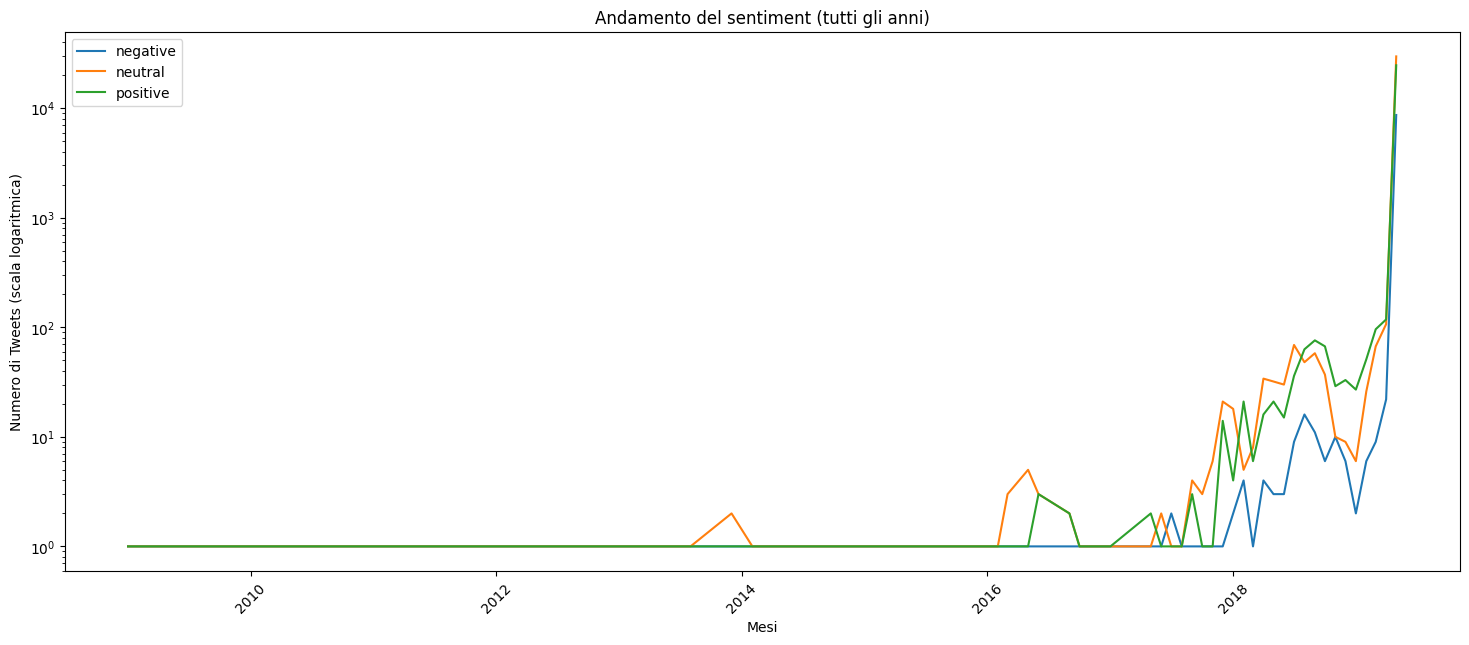

Nel 2019 il sentiment prevalente è stato quello positivo


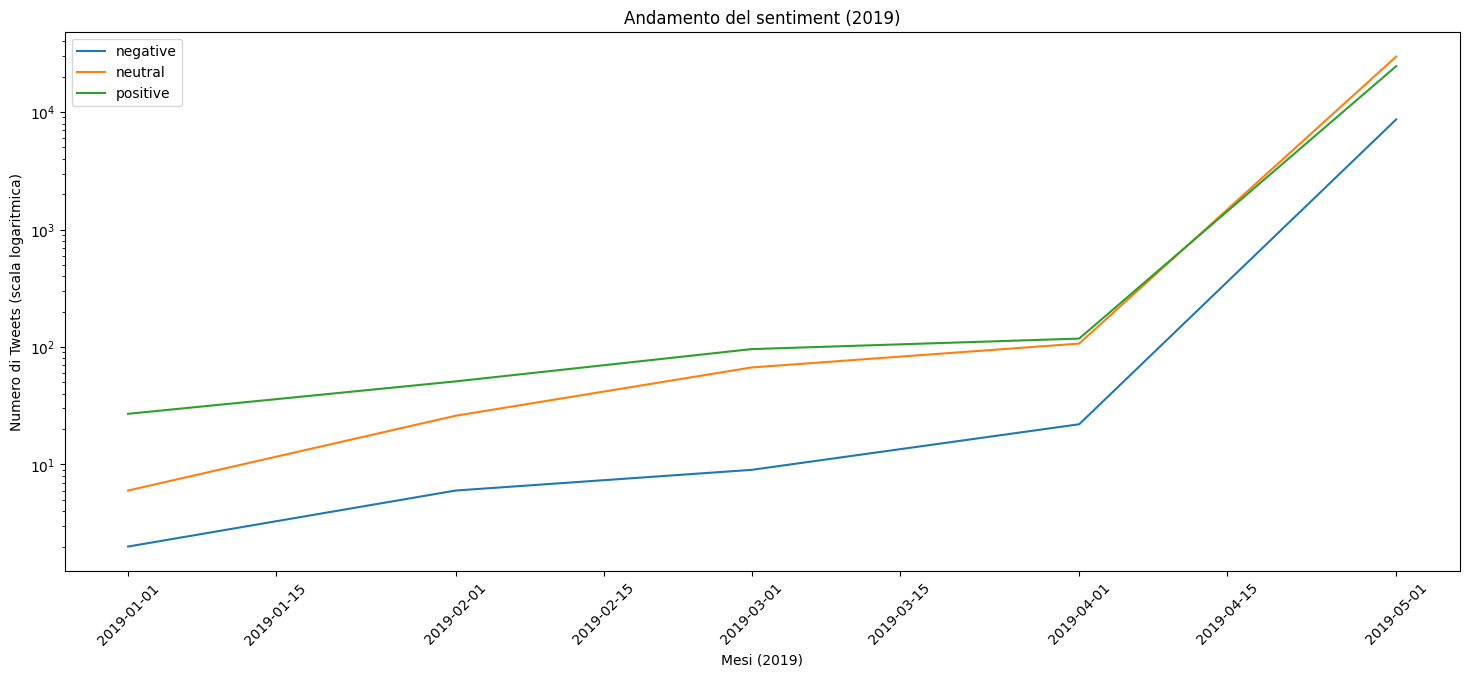

in media ci sono piu' interazioni e risposte sui tweet con sentiment negativo. Normalmente però il sentiment negativo suscita piu' interesse e interazione
likes per tweets 

+---------+------------------+

|sentiment|         avg_likes|

+---------+------------------+

| positive| 7.814065741183979|

| negative|10.824766085248932|

+---------+------------------+
replies per tweets

+---------+------------------+

|sentiment|       avg_replies|

+---------+------------------+

| positive|1.1185811754378965|

| negative|1.1904982082996185|

+---------+------------------+
non sembra esserci correlazione tra sentiment e variazione del prezzo dei bitcoin
joined_df

+----------+--------------+------------------+

|      date|sentiment_diff|        price_diff|

+----------+--------------+------------------+

|2014-12-12|             1| 2.035980224609375|

|2015-02-14|             0|21.894012451171875|

|2016-02-19|            -1|-1.587982177734375|

|2016-03-28|             0|-2.5340270996093

In [ ]:



print("----ANALISI DEL SENTIMENT SUL BITCOIN TRAMITE TWEET----")

"""non potendo sfruttare la potenza del calcolo distribuito copio e incollo i risultati ottenuti in precendeza.\n
  normalmente avrei usato:  likes_per_tweets.show() / replies_per_tweets.show() /joined_df.show()"""


print("'Negli anni si nota un crescente interesse e quindi di interazioni per i Bitcoin. I sentiment prevalenti sono quelli neutrali o positivi")

plot_sentiment(sentiment_pivot_monthly, title="Andamento del sentiment (tutti gli anni)")

print("Nel 2019 il sentiment prevalente è stato quello positivo")

plot_sentiment(sentiment_2019, title="Andamento del sentiment (2019)", xlabel="Mesi (2019)")

print("in media ci sono piu' interazioni e risposte sui tweet con sentiment negativo. Normalmente però il sentiment negativo suscita piu' interesse e interazione")


print("""likes per tweets \n
+---------+------------------+\n
|sentiment|         avg_likes|\n
+---------+------------------+\n
| positive| 7.814065741183979|\n
| negative|10.824766085248932|\n
+---------+------------------+""")



print("""replies per tweets\n
+---------+------------------+\n
|sentiment|       avg_replies|\n
+---------+------------------+\n
| positive|1.1185811754378965|\n
| negative|1.1904982082996185|\n
+---------+------------------+""")





print("non sembra esserci correlazione tra sentiment e variazione del prezzo dei bitcoin")
print("""joined_df\n
+----------+--------------+------------------+\n
|      date|sentiment_diff|        price_diff|\n
+----------+--------------+------------------+\n
|2014-12-12|             1| 2.035980224609375|\n
|2015-02-14|             0|21.894012451171875|\n
|2016-02-19|            -1|-1.587982177734375|\n
|2016-03-28|             0|-2.534027099609375|\n
|2016-05-03|             0| 5.634979248046875|\n
|2016-05-15|             1| 1.897003173828125|\n
|2016-05-19|             0|-15.90399169921875|\n
|2016-05-25|             0| 3.618011474609375|\n
|2016-06-15|             0|  8.90997314453125|\n
|2016-06-16|             3|  71.8389892578125|\n
+----------+--------------+------------------+""")


print(f"la correlazione tra sentiment e prezzo BTC è {correlation:.2f}")
print(f"Correlazione sentiment OGGI VS prezzo DOMANI : {corr_sentiment_to_price:.2f}")
print(f"Correlazione prezzo OGGI VS sentiment DOMANI : {corr_price_to_sentiment:.2f}")